# Поиск "Менделевских ошибок" при оценке качества генотипов
Может так случиться, что при проведении генетического анализа у человека описывается аллель, которая не была принята ни от одного из его родителей. Такая ситуация называется **менделевской ошибкой**.

Чтобы оценить правильность генетического анализа, нужно воспользоваться правилами *мендельского наследования* - закономерность между генотипами родителей и потомков:
- мать: *АА*, отец: *АА* => потомки: *АА*
- мать: *АА*, отец: *ТТ* => потомки: *АТ*
- мать: *АА*, отец: *АТ* => потомки: *АА* или *АТ*
- мать: *АТ*, отец: *АТ* => потомки: *любое* сочетание

Предположим, что у нас есть 20 потомков от родителей с генотипами как в третьем примере (мать: АА, отец: АТ). А мы хотим узнать, какая часть потомков будет *гетерозиготной (т.е. с геотипом АТ)*. Выясним это на примере.

Для начала импортируем парочку библиотек:

In [1]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

Создадим случайное распределение генотипов потомков, в котором:
- 100000 симуляций-моделей ("семей")
- 20 потомков у каждой "семьи"

Число потомков с генотипом АА: 0


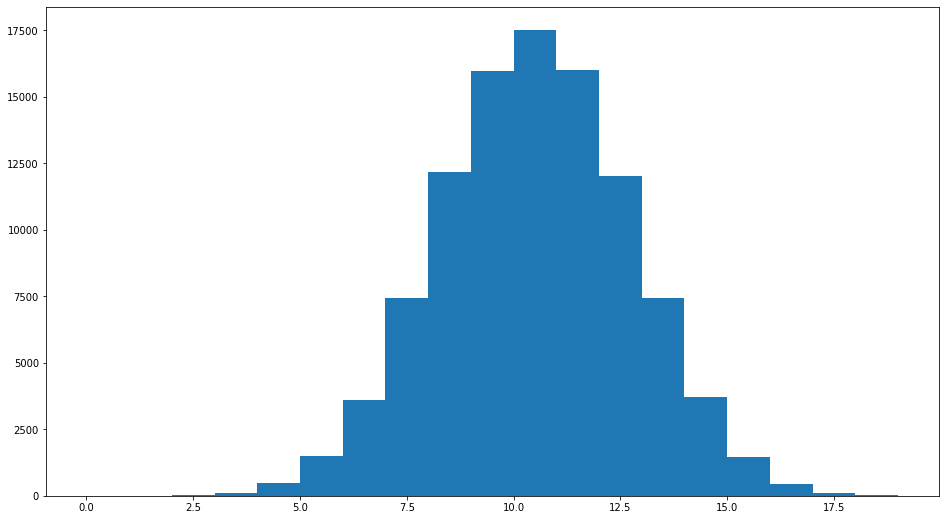

In [2]:
num_sims = 100000
num_ofs = 20
num_hets_AA_AT = []
for sim in range(num_sims):
    sim_hets = 0
    for ofs in range(20):
        sim_hets += 1 if random.choice([0, 1]) == 1 else 0
    num_hets_AA_AT.append(sim_hets)
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.hist(num_hets_AA_AT, bins=range(20))
print(f"Число потомков с генотипом АА: {len([num_hets for num_hets in num_hets_AA_AT if num_hets==20])}")

Согласно нашим результатам *(распределение случайное, ваши результаты могут быть иными)*, среди потомков не оказалось таких, что имеют генотип АА.

Теперь проведем тот же анализ для "семей", где генотип матерей и отцов одинаковый - АТ:

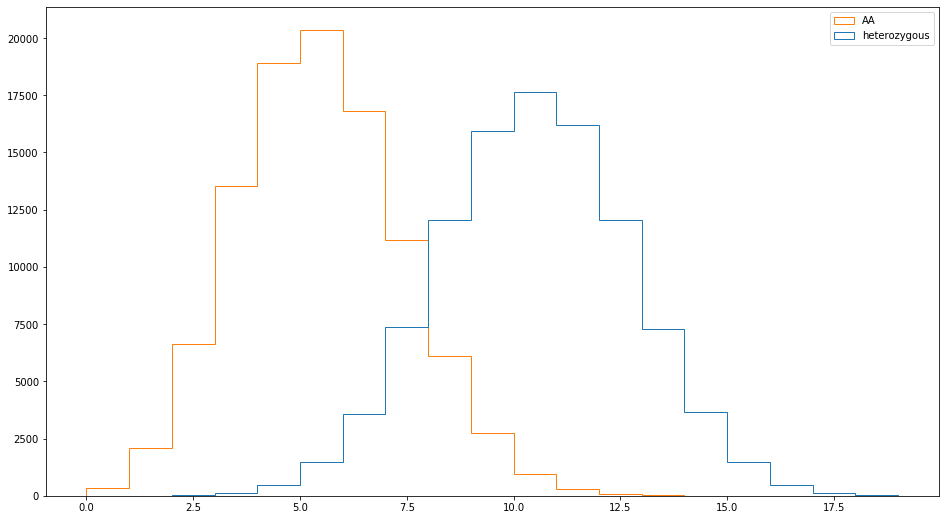

In [3]:
num_AAs_AT_AT = []
num_hets_AT_AT = []
for sim in range(num_sims):
    sim_AAs = 0
    sim_hets = 0
    for ofs in range(20):
        derived_cnt = sum(random.choices([0, 1], k=2))
        sim_AAs += 1 if derived_cnt == 0 else 0
        sim_hets += 1 if derived_cnt == 1 else 0
    num_AAs_AT_AT.append(sim_AAs)
    num_hets_AT_AT.append(sim_hets)
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.hist([num_hets_AT_AT, num_AAs_AT_AT], histtype='step', fill=False, bins=range(20), label=['heterozygous', 'AA'])
plt.legend()

Теперь посмотрим на другой пример: предположим, что у нас есть некоторая информация о генотипах (также по родителям и около 20 потомкам), а мы хотели бы посчитать менделевские ошибки. Данные возьмем из датасета по комарам, где есть информация о скрещивании особей. Рассматривать будем хромосому 3L. 

**Внимание:** т.к. размер файла 5.2Gb мы не стали его выкладывать - скачайте его самостоятельно (загрузка может занять около получаса).

In [ ]:
import wget

In [ ]:
wget.download("ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.3L.h5")

Для дальнейшей работы подключаем несколько библиотек:

In [ ]:
import pickle
import gzip
import random
import numpy as np
import h5py
import pandas as pd

Прежде всего нам понадобятся несколько метрик из этого датасета:
- MQ0 (mapping quality zero) и MQ (mapping quality) - величины, показывающие насколько хорошо последовательности генотипа соответствуют его позиции
- QD - метрика для измерения дисперсии
- Coverage - показывает схожесть последовательностей
<br>И некоторые другие величины.

*Не забудьте поменять пути при необходимости!*

In [ ]:
h5_3L = h5py.File('ag1000g.crosses.phase1.ar3sites.3L.h5', 'r')
samples_hdf5 = list(map(lambda sample: sample.decode('utf-8'), h5_3L['/3L/samples']))

calldata_genotype = h5_3L['/3L/calldata/genotype']

MQ0 = h5_3L['/3L/variants/MQ0']
MQ = h5_3L['/3L/variants/MQ']
QD = h5_3L['/3L/variants/QD']
Coverage = h5_3L['/3L/variants/Coverage']
CoverageMQ0 = h5_3L['/3L/variants/CoverageMQ0']
HaplotypeScore = h5_3L['/3L/variants/HaplotypeScore']
QUAL = h5_3L['/3L/variants/QUAL']
FS = h5_3L['/3L/variants/FS']
DP = h5_3L['/3L/variants/DP']
HRun = h5_3L['/3L/variants/HRun']
ReadPosRankSum = h5_3L['/3L/variants/ReadPosRankSum']
my_features = {
    'MQ': MQ,
    'QD': QD,
    'Coverage': Coverage,
    'HaplotypeScore': HaplotypeScore,
    'QUAL': QUAL,
    'FS': FS,
    'DP': DP,
    'HRun': HRun,
    'ReadPosRankSum': ReadPosRankSum
}

num_features = len(my_features)
num_alleles = h5_3L['/3L/variants/num_alleles']
is_snp = h5_3L['/3L/variants/is_snp']
POS = h5_3L['/3L/variants/POS']

Теперь создадим функцию, позволяющую вычислять менделевские ошибки. Основываться будем на правилах *менделевского наследования*, о котором мы говорили в самом начале. Т.е. мы распишем все возможные ситуации генотипа у родителей и потомков:

In [ ]:
def compute_mendelian_errors(mother, father, offspring):
    num_errors = 0
    num_ofs_problems = 0
    if len(mother.union(father)) == 1:
        # Одинаковые генотипы отца и матери
        for ofs in offspring:
            if len(ofs) == 2:
                # Потомок гетерозиготен
                num_errors += 1
                num_ofs_problems += 1
            elif len(ofs.intersection(mother)) == 0:
                # Потомок гомозиготен, в отличие от родителей
                num_errors += 2
                num_ofs_problems += 1
    elif len(mother) == 1 and len(father) == 1:
        # Отец и мать гомозиготны и различны
        for ofs in offspring:
            if len(ofs) == 1:
                # Гомозиготный, а должен быть гетерозиготный
                num_errors += 1
                num_ofs_problems += 1
    elif len(mother) == 2 and len(father) == 2:
        # Родители гетерозиготные, потомок любой
        pass
    else:
        # Один гетерозиготный, второй гомозиготный
        homo = mother if len(mother) == 1 else father
        for ofs in offspring:
            if len(ofs) == 1 and ofs.intersection(homo):
                # Гомозиготный, но без включения аллели от гомозиготного родителя
                num_errors += 1
                num_ofs_problems += 1
    return num_errors, num_ofs_problems

Теперь нам понадобится *генератор* и функция для выбора подходящих позиций генотипа:

In [ ]:
def acceptable_position_to_genotype():
    for i, genotype in enumerate(calldata_genotype):
        if is_snp[i] and num_alleles[i] == 2:
            if len(np.where(genotype == -1)[0]) > 1:
                continue
            yield i
def acumulate(fun):
    acumulator = {}
    for res in fun():
        if res is not None:
            acumulator[res[0]] = res[1]
    return acumulator

Далее нужно найти индексы скрещивания генотипов (мать, отец и 20 потомков) в файле HDF5 - создаем следующую функцию: 

In [ ]:
def get_family_indexes(samples_hdf5, cross_pd):
    offspring = []
    for i, individual in cross_pd.T.iteritems():
        index = samples_hdf5.index(individual.id)
        if individual.function == 'parent':
            if individual.sex == 'M':
                father = index
            else:
                mother = index
        else:
            offspring.append(index)
    return {'mother': mother, 'father': father, 'offspring': offspring}

cross_pd = samples[samples['cross'] == 'cross-29-2']
family_indexes = get_family_indexes(samples_hdf5, cross_pd)

И теперь мы рассчитываем менделевские ошибки и сохраняем их на диск:

In [ ]:
mother_index = family_indexes['mother']
father_index = family_indexes['father']
offspring_indexes = family_indexes['offspring']
all_errors = {}

In [ ]:
def get_mendelian_errors():
    for i in acceptable_position_to_genotype():
        genotype = calldata_genotype[i]
        mother = set(genotype[mother_index])
        father = set(genotype[father_index])
        offspring = [set(genotype[ofs_index]) for ofs_index in offspring_indexes]
        my_mendelian_errors = compute_mendelian_errors(mother, father, offspring)
        yield POS[i], my_mendelian_errors
    
mendelian_errors = acumulate(get_mendelian_errors)
pickle.dump(mendelian_errors, gzip.open('mendelian_errors.pickle.gz', 'wb'))